## Pre-Processing

In [1]:
from source import data_import
from source.constants import CHANNELS, DEFAULT_PATIENTS
import numpy as np
import matplotlib.pyplot as plt

import os
import pandas as pd
# os.environ["MODIN_ENGINE"] = "ray"
# import modin.pandas as pd
# import ray
# ray.shutdown()
# ray.init()


from source.filter_eeg_channels import filter_eeg_channels
from source.calculate_mean_psd import calculate_mean_psd
from source.constants import CHANNELS, FREQUENCY_RANGES
                                            
from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler

In [2]:
def load_file(file_name):
    if file_name.endswith('.arrow'):
        return data_import.load_pyarrow(file_name=file_name)
    elif file_name.endswith('.npy'):
        print('loading npy')
        return np.load('data/' + file_name, allow_pickle=True)
    else:
        print('no filename provided, trying npy')
        try:
            np.load('data/' + file_name + '.npy', allow_pickle=True)
        except FileNotFoundError:
            print('no npy file found, trying arrow')
            return data_import.load_pyarrow(file_name=file_name + '.arrow')
        
def save_file(data, file_name):
    if file_name is None:
        print('skipping save file.')
    elif file_name.endswith('.arrow'):
        data_import.save_pyarrow(data, file_name=file_name)
    elif file_name.endswith('.npy'):
        print('saving npy')
        np.save('data/' + file_name, data)
    else:
        print('no filetype provided, saving as npy')
        np.save('data/' + file_name + '.npy', data)

In [3]:
## PARAMETERS ##
SKIP_DATA = False
data_filename = None #"preprocessed_240_dur4.arrow" # data will be loaded/saved with this filename. Put None to skip saving the file

SKIP_FEATURES = False
feature_filename = 'features_240_dur4.npy' # data will be loaded/saved with this filename. Put None to skip saving the file

### DATA ###
# Load Patient Data #
patient_ids = DEFAULT_PATIENTS #DEFAULT_PATIENTS # use DEFAULT_PATIENTS for default patients selection
nr_segments=240
segment_duration=4
ictal_segmentation_foo=data_import.preictal_segmentation
interictal_segmentation_foo=data_import.inter_segmentation
channels=CHANNELS
seizure_offset=0

# filter #
exclude_ranges=[[58, 62], [118, 122]]

### FEATURES ###
target_colname = 'target'
PRED_INTERVAL = 6000 # how long should a segment count as preictal in seconds

window_size = 30 # Define the sequence_train window size

In [4]:
if not SKIP_DATA:
    # Load Patient Data
    p_df = data_import.load_segmented_data(patient_ids=patient_ids,
                                            nr_segments=nr_segments,
                                            segment_duration=segment_duration,
                                            ictal_segmentation_foo=data_import.preictal_segmentation,
                                            interictal_segmentation_foo=data_import.inter_segmentation,
                                            channels=channels,
                                            seizure_offset=seizure_offset
                                            )
    
    # Filter
    fit_df = filter_eeg_channels(p_df, CHANNELS, fs=256, exclude_ranges=exclude_ranges, Q=30)
    pd_toconcat = p_df[['epoch', 'segment_id']]
    fit_df = pd.concat(objs=[fit_df, pd_toconcat], axis =1)
    save_file(data=fit_df, file_name=data_filename)
    fit_df.head()
elif data_filename is not None:
    fit_df = load_file(data_filename)
    fit_df = pd.DataFrame(fit_df)
    fit_df.head()


chb01_01.edf was import but not resampled 256Hz.
chb01_02.edf was import but not resampled 256Hz.
chb01_03.edf was import but not resampled 256Hz.
chb01_03.edf seizure and buffer was labeled
chb01_04.edf was import but not resampled 256Hz.
chb01_04.edf seizure and buffer was labeled
chb01_05.edf was import but not resampled 256Hz.
chb01_06.edf was import but not resampled 256Hz.
chb01_07.edf was import but not resampled 256Hz.
chb01_08.edf was import but not resampled 256Hz.
chb01_09.edf was import but not resampled 256Hz.
chb01_10.edf was import but not resampled 256Hz.
chb01_11.edf was import but not resampled 256Hz.
chb01_12.edf was import but not resampled 256Hz.
chb01_13.edf was import but not resampled 256Hz.
chb01_14.edf was import but not resampled 256Hz.
chb01_15.edf was import but not resampled 256Hz.
chb01_15.edf seizure and buffer was labeled
chb01_16.edf was import but not resampled 256Hz.
chb01_16.edf seizure and buffer was labeled
chb01_17.edf was import but not resample

## Feature Extraction

In [5]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_psd(x, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_psd(x, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_psd(x, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

### aggregate mean features:
abs_mean = lambda x: x.apply(abs).mean()
abs_mean_agg = pd.NamedAgg(column='abs_mean', aggfunc=abs_mean)

### aggregate Functions for target:
target_foo = lambda x, pred_interval=PRED_INTERVAL: 0 < x.dt.total_seconds().min() < pred_interval

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, window_size):
    # Grouping and aggregating features
    df_features = df.groupby(['epoch', 'segment_id']).agg(
        {C: ['std', 'var', abs_mean_agg, delta_agg, theta_agg, gamma_agg] for C in CHANNELS} | 
        {target_colname: [target_foo]}
    )
    
    # Renaming columns
    df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if target_colname != col[0]] + [target_colname]
    df_features.reset_index(inplace=True)


    # Reshaping array
    original_array = np.array(df_features)
    epoch_column = original_array[:, 0]
    num_epochs = df_features.epoch.unique()[-1]
    num_segments = len(df_features.segment_id.unique())
    reshaped_array = np.empty((num_epochs, num_segments, original_array.shape[1]))

    for epoch in range(num_epochs):
        start_idx = epoch * num_segments
        end_idx = (epoch + 1) * num_segments
        reshaped_array[epoch, :, :] = original_array[start_idx:end_idx, :]

    # Creating sequence trains
    num_batches, num_sequences, num_features = reshaped_array.shape
    num_augmented_batches = num_sequences - window_size + 1

    data = np.zeros((num_batches * num_augmented_batches, window_size, num_features))

    for batch_idx in range(num_batches):
        for seq_idx in range(num_augmented_batches):
            data[batch_idx * num_augmented_batches + seq_idx, :, :] = reshaped_array[batch_idx, seq_idx:seq_idx + window_size, :]
        
    return data

In [7]:
if not SKIP_FEATURES:
    data = preprocess_data(fit_df, window_size=window_size)
    print(data.shape)
    save_file(data=data, file_name=feature_filename)
else:
    data = load_file(feature_filename)

(90097, 30, 63)
saving npy



data already loaded in parent notebook
341 of epochs for training, 86 of epochs for testing/validation
train shape (71951, 30, 62) ratio of seizures 0.12
test shape (18146, 30, 62), ratio of seizures 0.10
train shape (71951, 30, 60)
test shape (18146, 30, 60)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                32000     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization (Batch  (None, 64)                256

d:\_c\spiced\ai-seizure-detectives\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


576/576 [==============================] - 4s 6ms/step - loss: 8.0787 - accuracy: 0.4932 - auc: 0.5394 - val_loss: 7.6898 - val_accuracy: 0.4617 - val_auc: 0.5001
Epoch 3/300
576/576 [==============================] - 4s 6ms/step - loss: 7.5200 - accuracy: 0.4996 - auc: 0.5517 - val_loss: 7.1735 - val_accuracy: 0.4576 - val_auc: 0.5016
Epoch 4/300
576/576 [==============================] - 4s 6ms/step - loss: 7.0082 - accuracy: 0.5024 - auc: 0.5558 - val_loss: 6.6966 - val_accuracy: 0.4526 - val_auc: 0.5033
Epoch 5/300
576/576 [==============================] - 4s 6ms/step - loss: 6.5269 - accuracy: 0.5060 - auc: 0.5643 - val_loss: 6.2492 - val_accuracy: 0.4544 - val_auc: 0.5035
Epoch 6/300
576/576 [==============================] - 4s 6ms/step - loss: 6.0860 - accuracy: 0.5105 - auc: 0.5649 - val_loss: 5.8341 - val_accuracy: 0.4542 - val_auc: 0.5034
Epoch 7/300
576/576 [==============================] - 4s 6ms/step - loss: 5.6566 - accuracy: 0.5190 - auc: 0.5844 - val_loss: 5.4435 - v

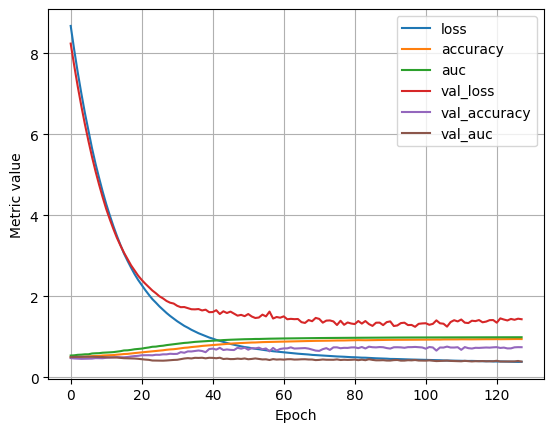

568/568 - 1s - loss: 1.0219 - accuracy: 0.7997 - auc: 0.5370 - 855ms/epoch - 2ms/step
Model accuracy: [1.0218875408172607, 0.7996803522109985, 0.5369868874549866]
568/568 [==============================] - 1s 2ms/step


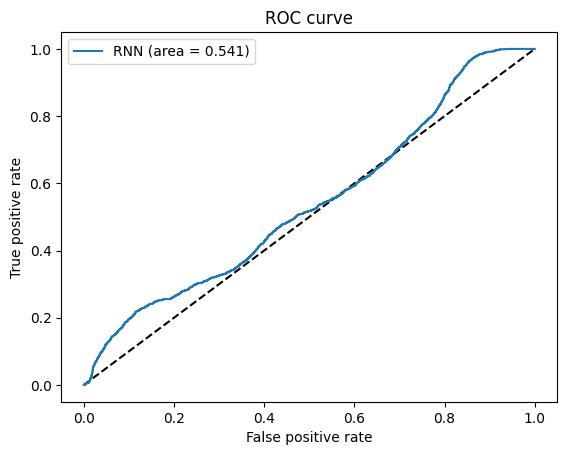

568/568 [==============================] - 1s 2ms/step - loss: 1.0219 - accuracy: 0.7997 - auc: 0.5370
Loss: 1.0218875408172607
Accuracy: 0.7996803522109985
AUC: 0.5369868874549866
Precision: 0.1674329501915709
Recall: 0.23012111637704055
Metrics:  ['loss', 'accuracy', 'auc']
Results:  [1.0218875408172607, 0.7996803522109985, 0.5369868874549866]


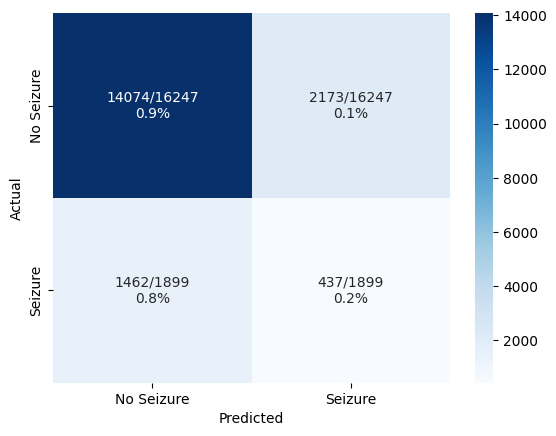

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89     16247
         1.0       0.17      0.23      0.19      1899

    accuracy                           0.80     18146
   macro avg       0.54      0.55      0.54     18146
weighted avg       0.83      0.80      0.81     18146



Ein Unterverzeichnis oder eine Datei mit dem Namen "-p" existiert bereits.
Folgender Fehler trat auf: -p.
Ein Unterverzeichnis oder eine Datei mit dem Namen "saved_model" existiert bereits.
Folgender Fehler trat auf: saved_model.


INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit\assets


INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit\assets


In [8]:
%run model_rnn.ipynb